<a href="https://colab.research.google.com/github/Aniket7773/Signature-Verification-Model/blob/main/Sign_verify2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the root directory path
root_dir = "/content/drive/MyDrive/Colab Notebooks/sign_data/train"

# Initialize empty lists to store file paths and labels
file_paths = []
labels = []

# Function to label images and append to lists
def label_images(directory, label):
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".PNG")):  # Assuming your images are in PNG format
            image_path = os.path.join(directory, filename)
            file_paths.append(image_path)
            labels.append(label)

# Traverse the directory structure and label images
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)

    if os.path.isdir(subdir_path):
        if subdir.endswith("_forg"):
            label = 0  # Forgery label
        else:
            label = 1  # Genuine label

        image_dir = os.path.join(subdir_path)
        if os.path.exists(image_dir):
            label_images(image_dir, label)

# Split the data into genuine and forged signatures
genuine_signatures = [file_paths[i] for i in range(len(file_paths)) if labels[i] == 1]
forged_signatures = [file_paths[i] for i in range(len(file_paths)) if labels[i] == 0]

# Create pairs of genuine and forged signatures
image_pairs = []
pair_labels = []

for genuine_path in genuine_signatures:
    for forged_path in forged_signatures:
        image_pairs.append((genuine_path, forged_path))
        # Label as similar (1) if both images are genuine or both are forged, dissimilar (0) otherwise
        pair_labels.append(int(genuine_path.split("/")[-2] == forged_path.split("/")[-2]))

# Shuffle and split the data into training and validation sets
image_pairs = np.array(image_pairs)
pair_labels = np.array(pair_labels)

X_train, X_val, y_train, y_val = train_test_split(image_pairs, pair_labels, test_size=0.2, random_state=42)

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (224, 224,1))  # Resize to your desired input size
    img = np.expand_dims(img, axis=-1)  # Add a single channel dimension
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Create a Siamese Network architecture
input_shape = (224, 224, 1)  # Adjust input shape based on your image size

base_model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
])

input_a = keras.layers.Input(shape=input_shape)
input_b = keras.layers.Input(shape=input_shape)

processed_a = base_model(input_a)
processed_b = base_model(input_b)

# Calculate L1 distance between the processed embeddings
distance = keras.layers.Lambda(lambda x: keras.backend.abs(x[0] - x[1]))([processed_a, processed_b])

# Output prediction (1 for similar, 0 for dissimilar)
output = keras.layers.Dense(1, activation='sigmoid')(distance)

# Create the Siamese model
siamese_model = keras.models.Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a data generator function for loading and preprocessing image pairs
def data_generator(image_pairs, pair_labels, batch_size):
    while True:
        indices = np.random.choice(len(image_pairs), batch_size)
        X_batch = [np.zeros((batch_size,) + input_shape) for _ in range(2)]
        y_batch = np.zeros((batch_size,))

        for i, idx in enumerate(indices):
            X_batch[0][i] = load_and_preprocess_image(image_pairs[idx][0])
            X_batch[1][i] = load_and_preprocess_image(image_pairs[idx][1])
            y_batch[i] = pair_labels[idx]

        yield X_batch, y_batch

# Train the Siamese model
batch_size = 32  # Adjust batch size as needed
steps_per_epoch1 = len(X_train) // batch_size
steps_per_epoch2 = (steps_per_epoch1) // batch_size
validation_steps = len(X_val) // batch_size

siamese_model.fit(
    data_generator(X_train, y_train, batch_size),
    epochs=1,  # Adjust the number of epochs
    steps_per_epoch=steps_per_epoch2,
    validation_data=data_generator(X_val, y_val, batch_size),
    validation_steps=validation_steps,
)
siamese_model.save('siamese-sign-verify.h5')

error: ignored

In [ ]:
def preprocess_single_image1(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Adjust to your model input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize pixel values
    return img.reshape(-1,224,224,1)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the saved CNN, and Siamese models
cnn_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/signature verification (1).h5')
siamese_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/siamese-sign-verify2.h5')


In [ ]:
# Define the root directory path for test data
test_dir = "/content/drive/MyDrive/Colab Notebooks/sign_data/test"


Forged image


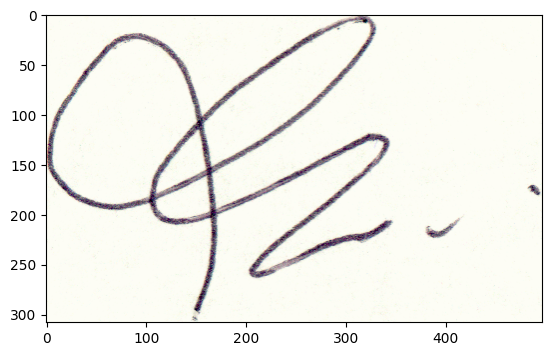

In [ ]:
import matplotlib.pyplot as plt
import cv2
img1=cv2.imread('/content/drive/MyDrive/Colab Notebooks/sign_data/test/049/01_049.png',cv2.IMREAD_ANYCOLOR)
img=cv2.imread('/content/drive/MyDrive/Colab Notebooks/sign_data/test/049_forg/01_0114049.PNG',cv2.IMREAD_ANYCOLOR)
print("Forged image")
plt.imshow(img)


Genuine image


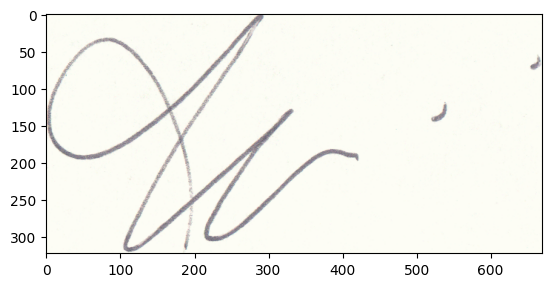

In [ ]:
print("Genuine image")
plt.imshow(img1)

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Define the function to preprocess a single image
def preprocess_single_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))  # Adjust to your model input size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img / 255.0  # Normalize pixel values
    return img

# Load a single image for testing
image_path = "/content/drive/MyDrive/Colab Notebooks/sign_data/test/049/03_049.png"  # Replace with your image path
preprocessed_image = preprocess_single_image(image_path)
preprocessed_image1 = preprocess_single_image1(image_path)
# Load the saved CNN model for signature verification
cnn_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/cnn-signature verification.h5')  # Replace with your model name
siamese_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/siamese-sign-verify2.h5')
# Make a prediction using the CNN model
prediction = cnn_model.predict(np.expand_dims(preprocessed_image, axis=0))
prediction1 = siamese_model.predict([preprocessed_image1, preprocessed_image1])
ensemble_prediction = (prediction + prediction1) / 2.0
if np.any(ensemble_prediction > 0.5):
    print("The signature is classified as GENUINE.")
else:
    print("The signature is classified as FORGED.")


1/1 [==============================] - 0s 314ms/step
The signature is classified as GENUINE.


In [ ]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  1009344   ['input_1[0][0]',             
                                                          00         'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['sequential[0][0]',      

In [ ]:
siamese_model.history

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 21137729 (80.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
